<a href="https://colab.research.google.com/github/AbhiJeet70/GraphPoisoningCodes/blob/main/Poison_Air_Number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing country: USA
Statistics for USA:
  Number of nodes: 1190
  Number of edges: 13599
  Number of features: 1190
  Number of classes: 4
  Class distribution: [297 297 297 299]
Early stopping at epoch 104
Early stopping at epoch 106
Early stopping at epoch 123
Early stopping at epoch 131
Early stopping at epoch 349
Early stopping at epoch 419
Early stopping at epoch 105
Early stopping at epoch 105
Early stopping at epoch 120
Early stopping at epoch 119
Early stopping at epoch 292
Early stopping at epoch 225
Early stopping at epoch 103
Early stopping at epoch 105
Early stopping at epoch 114
Early stopping at epoch 116
Early stopping at epoch 205
Early stopping at epoch 201
Early stopping at epoch 116
Early stopping at epoch 105
Early stopping at epoch 111
Early stopping at epoch 112
Early stopping at epoch 175
Early stopping at epoch 167
Early stopping at epoch 105
Early stopping at epoch 106
Early stopping at epoch 111
Early stopping at epoch 114
Early stopping at epoch 163
Early

/tmp/ipykernel_34/3803400329.py:225: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Early stopping at epoch 126
Perturbation Type: Evenly, Perturbation Percentage: 0.05, Accuracy: 0.4309623430962343
Number of nodes used for perturbation: 4
Early stopping at epoch 301
Perturbation Type: Concentrated, Perturbation Percentage: 0.05, Accuracy: 0.45188284518828453
Early stopping at epoch 130
Perturbation Type: Evenly, Perturbation Percentage: 0.1, Accuracy: 0.4351464435146444
Number of nodes used for perturbation: 8
Early stopping at epoch 137
Perturbation Type: Concentrated, Perturbation Percentage: 0.1, Accuracy: 0.4225941422594142
Early stopping at epoch 145
Perturbation Type: Evenly, Perturbation Percentage: 0.15, Accuracy: 0.39330543933054396
Number of nodes used for perturbation: 13
Early stopping at epoch 117
Perturbation Type: Concentrated, Perturbation Percentage: 0.15, Accuracy: 0.4895397489539749
Early stopping at epoch 143
Perturbation Type: Evenly, Perturbation Percentage: 0.2, Accuracy: 0.4309623430962343
Number of nodes used for perturbation: 17
Early stoppi

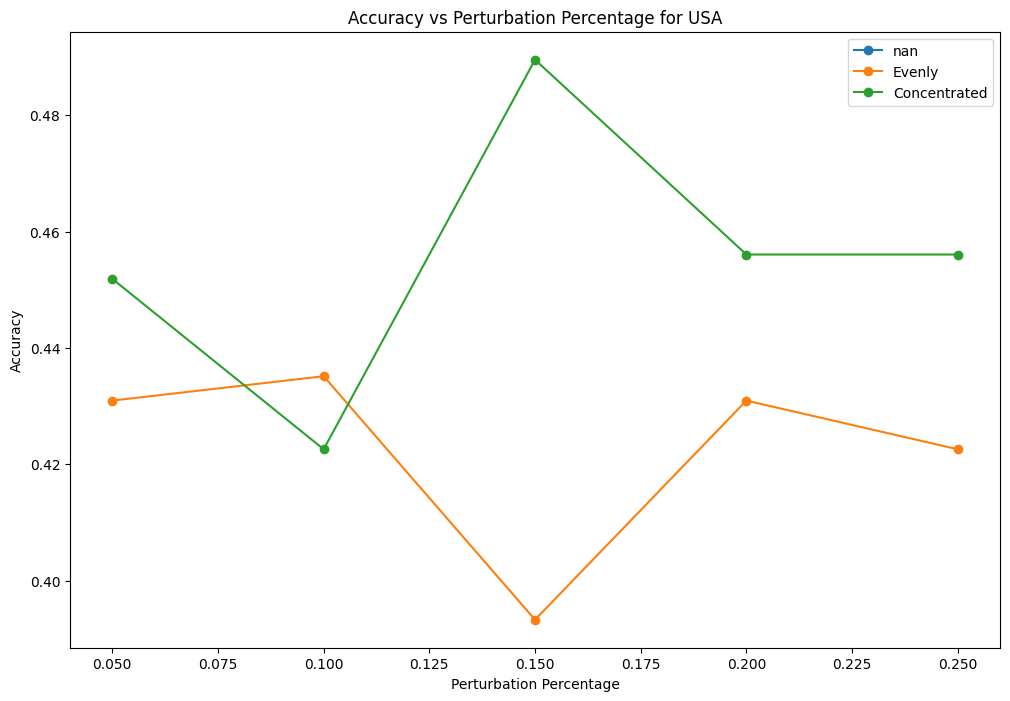

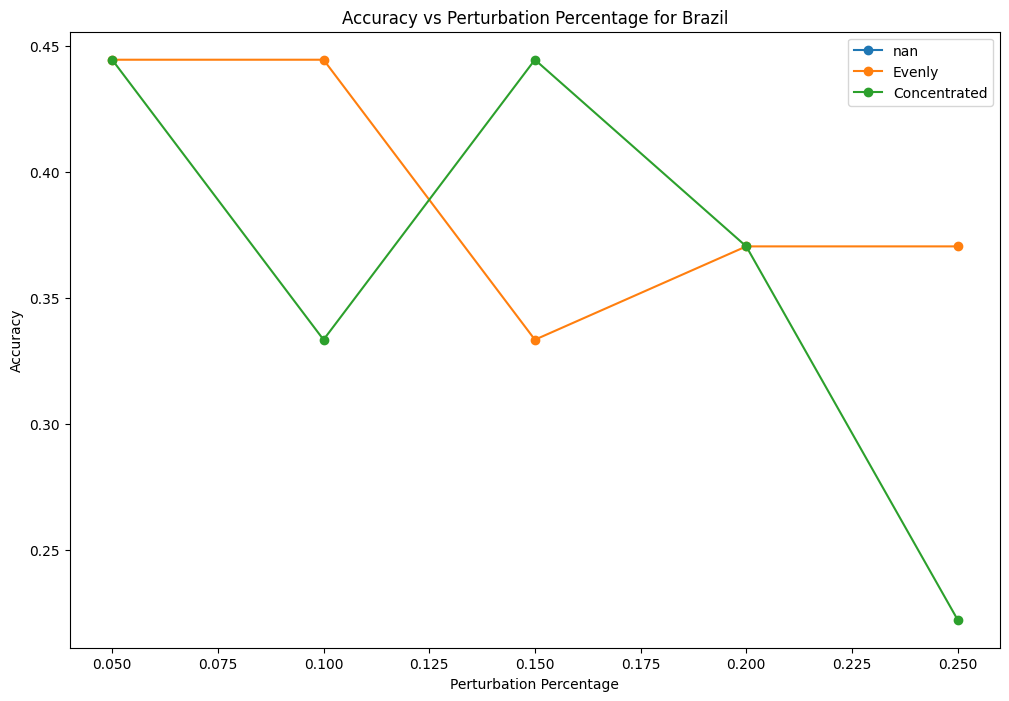

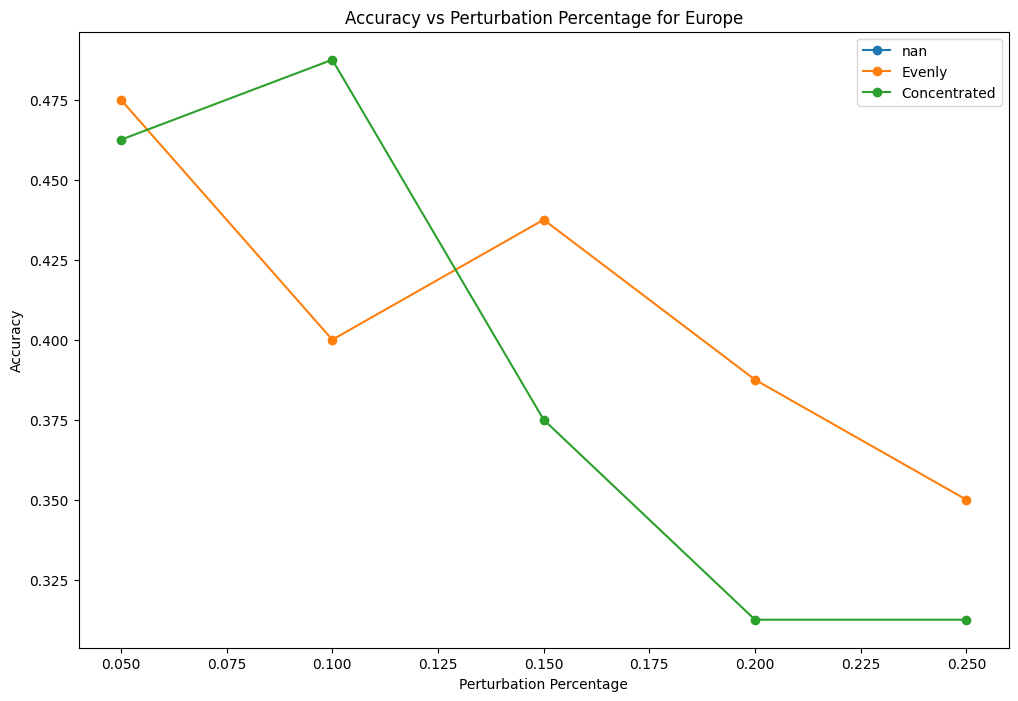

In [ ]:
# Install necessary packages
!pip install torch torch-geometric pandas matplotlib

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Airports
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(20)

# Define function to load Airports data for a given country
def load_airports_data(country):
    dataset = Airports(root='/tmp/Airports', name=country, transform=NormalizeFeatures())
    data = dataset[0]
    return data

# Split data into train, validation, and test sets (if needed)
def split_indices(num_nodes, train_ratio=0.7, val_ratio=0.1):
    indices = np.random.permutation(num_nodes)
    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)
    train_idx = torch.tensor(indices[:train_end], dtype=torch.long)
    val_idx = torch.tensor(indices[train_end:val_end], dtype=torch.long)
    test_idx = torch.tensor(indices[val_end:], dtype=torch.long)
    return train_idx, val_idx, test_idx

# Define the GCN model with 2 layers
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train and evaluate the model
def train_model(model, pyg_data, lr, weight_decay):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pyg_data = pyg_data.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience = 100
    patience_counter = 0

    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(pyg_data.x, pyg_data.edge_index)
        loss = F.cross_entropy(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
        val_correct = float(pred[pyg_data.val_mask].eq(pyg_data.y[pyg_data.val_mask]).sum().item())
        val_acc = val_correct / pyg_data.val_mask.sum().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_model_state)
    model.eval()
    _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
    correct = float(pred[pyg_data.test_mask].eq(pyg_data.y[pyg_data.test_mask]).sum().item())
    acc = correct / pyg_data.test_mask.sum().item()
    return acc

# Print dataset statistics
def print_dataset_statistics(data, country):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_node_features
    num_classes = data.y.max().item() + 1
    class_distribution = torch.bincount(data.y).cpu().numpy()
    print(f"Statistics for {country}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Number of features: {num_features}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Class distribution: {class_distribution}")

def evenly_perturb_edges(data, perturbation_percentage):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes
    num_perturbations = int(num_edges * perturbation_percentage)

    perturbations_per_node = num_perturbations // num_nodes
    remaining_perturbations = num_perturbations

    for node in range(num_nodes):
        if remaining_perturbations <= 0:
            break

        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)

        if perturb_edges_idx.size(0) > 0:
            num_perturb_node_edges = min(perturbations_per_node, perturb_edges_idx.size(0))
            selected_edges_idx = perturb_edges_idx[torch.randperm(perturb_edges_idx.size(0))[:num_perturb_node_edges]]
            edge_index[:, selected_edges_idx] = torch.randint(0, num_nodes, edge_index[:, selected_edges_idx].shape, dtype=torch.long, device=device)
            remaining_perturbations -= num_perturb_node_edges

    data.edge_index = edge_index
    return data

def concentrated_perturb_edges(data, perturbation_percentage):
    device = data.edge_index.device
    edge_index = data.edge_index.clone().to(device)
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes
    num_perturbations = int(num_edges * perturbation_percentage)

    # Compute node degrees
    degrees = torch.zeros(num_nodes, dtype=torch.long, device=device)
    degrees.scatter_add_(0, edge_index[0], torch.ones(edge_index.size(1), dtype=torch.long, device=device))

    # Sort nodes by degree in descending order
    sorted_nodes = torch.argsort(degrees, descending=True)
    total_perturbations = 0
    nodes_used = 0

    for node in sorted_nodes:
        if total_perturbations >= num_perturbations:
            break

        connected_edges = (edge_index[0] == node) | (edge_index[1] == node)
        perturb_edges_idx = torch.nonzero(connected_edges, as_tuple=False).view(-1)

        if perturb_edges_idx.size(0) > 0:
            num_node_edges = perturb_edges_idx.size(0)
            edge_index[:, perturb_edges_idx] = torch.randint(0, num_nodes, edge_index[:, perturb_edges_idx].shape, dtype=torch.long, device=device)
            total_perturbations += num_node_edges
            nodes_used += 1

    data.edge_index = edge_index
    print(f"Number of nodes used for perturbation: {nodes_used}")
    return data, nodes_used

# Hyperparameter grid search
hidden_channels_list = [16, 32, 64, 128, 256, 512]  # Reduced for quicker testing
learning_rates = [0.1, 0.01, 0.001]    # Reduced for quicker testing
weight_decays = [1e-4, 1e-5]

# List of datasets to process
countries = ['USA', 'Brazil', 'Europe']

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Country', 'Hidden_Channels', 'Learning_Rate', 'Weight_Decay', 'Accuracy', 'Perturbation_Type', 'Perturbation_Percentage'])

# Process each dataset and print accuracies
for country in countries:
    print(f'Processing country: {country}')
    data = load_airports_data(country)
    print_dataset_statistics(data, country)

    train_idx, val_idx, test_idx = split_indices(data.num_nodes)
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.val_mask[val_idx] = True
    data.test_mask[test_idx] = True

    # Determine number of classes from labels
    num_classes = data.y.max().item() + 1

    # Hyperparameter tuning
    best_accuracy = 0
    best_hyperparams = {}

    for hidden_channels in hidden_channels_list:
        for lr in learning_rates:
            for weight_decay in weight_decays:
                model = GCNNet(data.num_features, hidden_channels, num_classes)
                acc = train_model(model, data, lr, weight_decay)

                if acc > best_accuracy:
                    best_accuracy = acc
                    best_hyperparams = {
                        'Hidden_Channels': hidden_channels,
                        'Learning_Rate': lr,
                        'Weight_Decay': weight_decay
                    }

    # Report the best hyperparameters
    print(f"Best Hyperparameters for {country}: {best_hyperparams}")

    # Evaluate the best model
    model = GCNNet(data.num_features, best_hyperparams['Hidden_Channels'], num_classes)
    acc = train_model(model, data, best_hyperparams['Learning_Rate'], best_hyperparams['Weight_Decay'])
    print(f"Test Accuracy for {country}: {acc}")

    # Append results to DataFrame
    results_df = pd.concat([results_df, pd.DataFrame({
        'Country': [country],
        'Hidden_Channels': [best_hyperparams['Hidden_Channels']],
        'Learning_Rate': [best_hyperparams['Learning_Rate']],
        'Weight_Decay': [best_hyperparams['Weight_Decay']],
        'Accuracy': [acc],
        'Perturbation_Type': ['None'],
        'Perturbation_Percentage': [0]
    })], ignore_index=True)

    # Perturbation experiments
    perturbation_percentages = [0.05, 0.1, 0.15, 0.2, 0.25]

    for perturbation_percentage in perturbation_percentages:
        for perturbation_type in ['Evenly', 'Concentrated']:
            perturbed_data = data.clone()
            if perturbation_type == 'Evenly':
                perturbed_data = evenly_perturb_edges(perturbed_data, perturbation_percentage)
            else:
                perturbed_data, nodes_used = concentrated_perturb_edges(perturbed_data, perturbation_percentage)

            model = GCNNet(data.num_features, best_hyperparams['Hidden_Channels'], num_classes)
            acc = train_model(model, perturbed_data, best_hyperparams['Learning_Rate'], best_hyperparams['Weight_Decay'])
            print(f"Perturbation Type: {perturbation_type}, Perturbation Percentage: {perturbation_percentage}, Accuracy: {acc}")

            # Append perturbed results to DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'Country': [country],
                'Hidden_Channels': [best_hyperparams['Hidden_Channels']],
                'Learning_Rate': [best_hyperparams['Learning_Rate']],
                'Weight_Decay': [best_hyperparams['Weight_Decay']],
                'Accuracy': [acc],
                'Perturbation_Type': [perturbation_type],
                'Perturbation_Percentage': [perturbation_percentage]
            })], ignore_index=True)

# Save results to a CSV file
results_df.to_csv('gcn_perturbation_results.csv', index=False)

# Plot results
def plot_results(df):
    countries = df['Country'].unique()

    for country in countries:
        fig, ax = plt.subplots(figsize=(12, 8))
        country_df = df[df['Country'] == country]

        for perturbation_type in country_df['Perturbation_Type'].unique():
            subset = country_df[country_df['Perturbation_Type'] == perturbation_type]
            ax.plot(subset['Perturbation_Percentage'], subset['Accuracy'], marker='o', label=f'{perturbation_type}')

        ax.set_xlabel('Perturbation Percentage')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'Accuracy vs Perturbation Percentage for {country}')
        ax.legend()
        plt.show()

# Load the results from CSV
results_df = pd.read_csv('gcn_perturbation_results.csv')

# Plot the results
plot_results(results_df)
